In [71]:
# This code is written to support the experiments in the book titled:
# "Adaptive Machine Learning Algorithms"
# by
# Chanchal Chatterjee and Vwani P. Roychowdhury
# August 2021
#
# Experiments for Chapter 6 - Accelerated Principal and Minor Eigenvectors of a Matrix Sequence
#
# Author: Chanchal Chatterjee
#
# Speedup of the Adaptive EVD Algorithm 
# Compare Our Gradient Descent, Steepest Descent, Conjugate Direction, & Newton's Method
# for stationary data


In [72]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [73]:
covX1 = 2 * np.array([ \
[ 0.0910, 0.0380,-0.0530,-0.0050, 0.0100,-0.1360, 0.1550, 0.0300, 0.0020, 0.0320 ], \
[ 0.0380, 0.3730, 0.0180,-0.0280,-0.0110,-0.3670, 0.1540,-0.0570,-0.0310,-0.0650 ], \
[-0.0530, 0.0180, 1.4300, 0.0170, 0.0550,-0.4500,-0.0380,-0.2980,-0.0410,-0.0300 ], \
[-0.0050,-0.0280, 0.0170, 0.0840,-0.0050, 0.0160, 0.0420,-0.0220, 0.0010, 0.0050 ], \
[ 0.0100,-0.0110, 0.0550,-0.0050, 0.0710, 0.0880, 0.0580,-0.0690,-0.0080, 0.0030 ], \
[-0.1360,-0.3670,-0.4500, 0.0160, 0.0880, 5.7200,-0.5440,-0.2480, 0.0050, 0.0950 ], \
[ 0.1550, 0.1540,-0.0380, 0.0420, 0.0580,-0.5440, 2.7500,-0.3430,-0.0110,-0.1200 ], \
[ 0.0300,-0.0570,-0.2980,-0.0220,-0.0690,-0.2480,-0.3430, 1.4500, 0.0780, 0.0280 ], \
[ 0.0020,-0.0310,-0.0410, 0.0010,-0.0080, 0.0050,-0.0110, 0.0780, 0.0670, 0.0150 ], \
[ 0.0320,-0.0650,-0.0300, 0.0050, 0.0030, 0.0950,-0.1200, 0.0280, 0.0150, 0.3410 ]])

covX1.shape

(10, 10)

In [74]:
from scipy.linalg import eigh

# Number of samples N and dimension D
nSamples1 = 2000
nSamples = nSamples1
nDim = 10
nEA = 4
nEpochs = 1

eigvals1, eigvecs1 = eigh(covX1)
print("eigvals1 =\n", eigvals1[::-1])
V1 = np.fliplr(eigvecs1)
D1  = np.diag(np.sqrt(eigvals1[::-1]))

np.random.seed(1)
R1 = np.random.normal(0, 1, (nDim, nSamples1))
X1 = V1 @ D1 @ R1


eigvals1 =
 [11.79962474  5.56438753  3.41750617  2.0588796   0.78726809  0.5877646
  0.17426915  0.14232806  0.12129678  0.10067527]


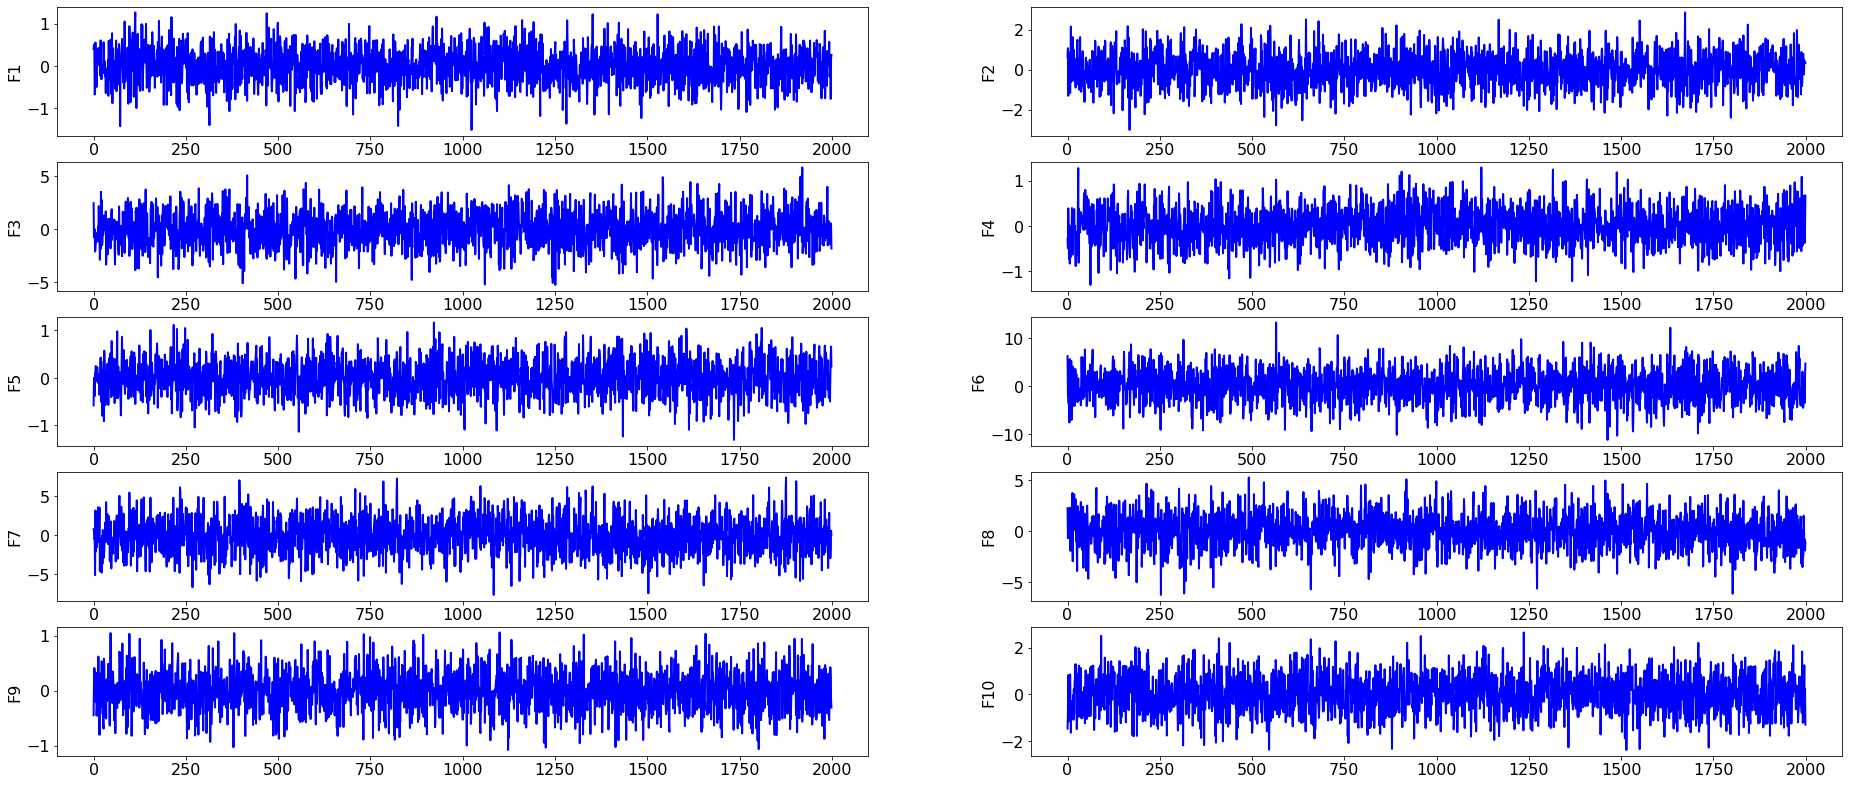

In [75]:
# Plot the data
dataset = pd.DataFrame(X1.T, columns=['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10'])
plt.figure(figsize=(32, 48))
plt.rcParams.update({'font.size': 16})
cols = dataset.columns
for i in range(dataset.shape[1]):
    plt.subplot(17, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(dataset[cols[i]], lw=2, color='b')
plt.show()


In [76]:
# Square root of the correlation matrix
from scipy.linalg import eigh

# Compute Correlation matrix and eigen vectors of the generated data
corX1 = (X1 @ X1.T) / nSamples1

# Eigenvalues and eigenvectors of corX1
eigvals1, eigvecs1 = eigh(corX1)
print("eigvals1 =\n", eigvals1[::-1])
EstV1 = np.fliplr(eigvecs1)
EstD1  = np.diag(eigvals1[::-1])


eigvals1 =
 [11.95823012  5.46527538  3.46206003  2.018293    0.78386353  0.59042246
  0.17380342  0.14364247  0.12324499  0.09713572]


In [77]:
# Initialize all variables for adaptive algorithm
from numpy import linalg as la

A  = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
W1 = 0.1 * np.ones(shape=(nDim,nEA)) # weight vectors of all algorithms
W2 = W1
W3 = W1
W4 = W1
I  = np.identity(nDim)
invB  = np.identity(nDim)

cos_t1 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error
cos_t2 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error
cos_t3 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error
cos_t4 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error

Weight = 1

for epoch in range(nEpochs):
    for iter in range(nSamples):
        cnt = nSamples*epoch + iter

        x = X1[:,iter]
        x = x.reshape(nDim,1)
        A = Weight * A + (1.0/(1 + cnt))*((np.dot(x, x.T)) - Weight * A)

        # Gradient Descent - Xu
        etat = 1.0/(400 + cnt)
        G = -2 * A @ W1 + A @ W1 @ np.triu(W1.T @ W1) + W1 @ np.triu(W1.T @ A @ W1)
        W1 = W1 - etat * G;

        # Steepest Descent
        G = -2 * A @ W2 + A @ W2 @ np.triu(W2.T @ W2) + W2 @ np.triu(W2.T @ A @ W2)
        for i in range(nEA):
            M = np.zeros(shape=(nDim,nDim))
            for k in range(i):
                wk = W2[:,k].reshape(nDim,1)
                M = M + (A @ (wk @ wk.T) + (wk @ wk.T) @ A)
            wi = W2[:,i].reshape(nDim,1)
            F = - 2*A + 2*A @ (wi @ wi.T) + 2 * (wi @ wi.T) @ A + A * (wi.T @ wi) + \
                    (wi.T @ A @ wi) * I  +  M
            gi = G[:,i].reshape(nDim,1)
            a0 = np.asscalar(gi.T @ gi)
            a1 = np.asscalar(- gi.T @ F @ gi)
            a2 = np.asscalar(3 * ((wi.T @ A @ gi) @ (gi.T @ gi) + (gi.T @ A @ gi)*(wi.T @ gi)))
            a3 = np.asscalar(- 2 * (gi.T @ A @ gi) @ (gi.T @ gi))
            c  = np.array([a3, a2, a1, a0])
            rts = np.roots(c)

            rs = np.zeros(3)
            r  = np.zeros(3)
            J  = np.zeros(3)
            cnt1 = 0
            for k in range(3):
                if np.isreal(rts[k]):
                    re = np.real(rts[k])
                    rs[cnt1] = re
                    r = W2[:,i] - re * G[:,i]
                    J[cnt1] = np.asscalar(-2*(r.T @ A @ r) + (r.T @ A @ r) * (r.T @ r) + \
                                          (r.T @ M @ r))
                    cnt1 = cnt1 + 1
            yy = min(J)
            iyy = np.argmin(J)

            alpha = rs[iyy]
         
            W2[:,i] = (W2[:,i] - alpha * G[:,i]).T
 

        # Conjugate Direction Method

        # Initialize D
        G = -2 * A @ W3 + A @ W3 @ np.triu(W3.T @ W3) + W3 @ np.triu(W3.T @ A @ W3)
        if (iter == 0):
            D = -G  

        # Update W
        for i in range(nEA):
            M = np.zeros(shape=(nDim,nDim))
            for k in range(i):
                wk = W3[:,k].reshape(nDim,1)
                M = M + (A @ (wk @ wk.T) + (wk @ wk.T) @ A)
            wi = W3[:,i].reshape(nDim,1)
            F = - 2*A + 2*A @ (wi @ wi.T) + 2 * (wi @ wi.T) @ A + A * (wi.T @ wi) + \
                    (wi.T @ A @ wi) * I  +  M
 
            gi = G[:,i].reshape(nDim,1)
            di = D[:,i].reshape(nDim,1)
            a0 = np.asscalar(gi.T @ di)
            a1 = np.asscalar(di.T @ F @ di)
            a2 = np.asscalar(3 * ((wi.T @ A @ di) @ (di.T @ di) + (di.T @ A @ di)*(wi.T @ di)))
            a3 = np.asscalar(2 * (di.T @ A @ di) @ (di.T @ di))
            c  = np.array([a3, a2, a1, a0])
            rts = np.roots(c)

            rs = np.zeros(3)
            r  = np.zeros(3)
            J  = np.zeros(3)
            cnt1 = 0
            for k in range(3):
                if np.isreal(rts[k]):
                    re = np.real(rts[k])
                    rs[cnt1] = re
                    r = W3[:,i] + re * D[:,i]
                    J[cnt1] = np.asscalar(-2*(r.T @ A @ r) + (r.T @ A @ r) * (r.T @ r) + \
                                          (r.T @ M @ r))
                    cnt1 = cnt1 + 1
            yy = min(J)
            iyy = np.argmin(J)

            alpha = rs[iyy]
            W3[:,i] = (W3[:,i] + alpha * D[:,i]).T
      
        # Update d
        G = -2 * A @ W3 + A @ W3 @ np.triu(W3.T @ W3) + W3 @ np.triu(W3.T @ A @ W3)
        for i in range(nEA):
            wi = W3[:,i].reshape(nDim,1)
            gi = G[:,i].reshape(nDim,1)
            di = D[:,i].reshape(nDim,1)
            M = np.zeros(shape=(nDim,nDim))
            for k in range(i):
                wk = W3[:,k].reshape(nDim,1)
                M = M + (A @ (wk @ wk.T) + (wk @ wk.T) @ A)
            F = - 2*A + 2*A @ (wi @ wi.T) + 2 * (wi @ wi.T) @ A + A * (wi.T @ wi) + \
                    (wi.T @ A @ wi) * I  +  M
            beta = (gi.T @ F @ di) / (di.T @ F @ di)
            di = -gi + beta*di   
            D[:,i] = di.T
 
        # Newton Rhapson
        G = -2 * A @ W4 + A @ W4 @ np.triu(W4.T @ W4) + W4 @ np.triu(W4.T @ A @ W4)

        # Update W
        for i in range(nEA):
            M = np.zeros(shape=(nDim,nDim))
            for k in range(i):
                wk = W4[:,k].reshape(nDim,1)
                M = M + (A @ (wk @ wk.T) + (wk @ wk.T) @ A)
            wi = W4[:,i].reshape(nDim,1)
            F = - 2*A + 2*A @ (wi @ wi.T) + 2 * (wi @ wi.T) @ A + A * (wi.T @ wi) + \
                    (wi.T @ A @ wi) * I  +  M
 
            lam = wi.T @ A @ wi
            Atilde = A
            if (iter > 0):
                invB = (I + (Atilde/lam))/lam
            invC = invB - (2*invB @ A @ wi @ wi.T @ invB)/(1 + 2*wi.T @ invB @ A @ wi)
            invF = invC - (2*invC @ wi @ wi.T @ A @ invC)/(1 + 2*wi.T @ A @ invC @ wi)

            gi = G[:,i].reshape(nDim,1)
            di = -invF @ gi
            a0 = np.asscalar(gi.T @ di)
            a1 = np.asscalar(di.T @ F @ di)
            a2 = np.asscalar(3 * ((wi.T @ A @ di) @ (di.T @ di) + (di.T @ A @ di)*(wi.T @ di)))
            a3 = np.asscalar(2 * (di.T @ A @ di) @ (di.T @ di))
            c  = np.array([a3, a2, a1, a0])
            rts = np.roots(c)

            rs = np.zeros(3)
            r  = np.zeros(3)
            J  = np.zeros(3)
            cnt1 = 0
            for k in range(3):
                if np.isreal(rts[k]):
                    re = np.real(rts[k])
                    rs[cnt1] = re
                    r = W4[:,i] + re * di.reshape(nDim)
                    J[cnt1] = np.asscalar(-2*(r.T @ A @ r) + (r.T @ A @ r) * (r.T @ r) + \
                                          (r.T @ M @ r))
                    cnt1 = cnt1 + 1
            yy = min(J)
            iyy = np.argmin(J)

            alpha = rs[iyy]
            W4[:,i] = (W4[:,i] + alpha * di.reshape(nDim)).T
 
        # Store the results
        for i in range(nEA):
            u1 = W1[:,i]/la.norm(W1[:,i])
            u1 = u1.reshape(nDim,1)
            u2 = W2[:,i]/la.norm(W2[:,i])
            u2 = u2.reshape(nDim,1)
            u3 = W3[:,i]/la.norm(W3[:,i])
            u3 = u3.reshape(nDim,1)
            u4 = W4[:,i]/la.norm(W4[:,i])
            u4 = u4.reshape(nDim,1)
            vi = EstV1[:,i].reshape(nDim,1)
            cos_t1[i,cnt] = abs(u1.T @ vi)
            cos_t2[i,cnt] = abs(u2.T @ vi)
            cos_t3[i,cnt] = abs(u3.T @ vi)
            cos_t4[i,cnt] = abs(u4.T @ vi)


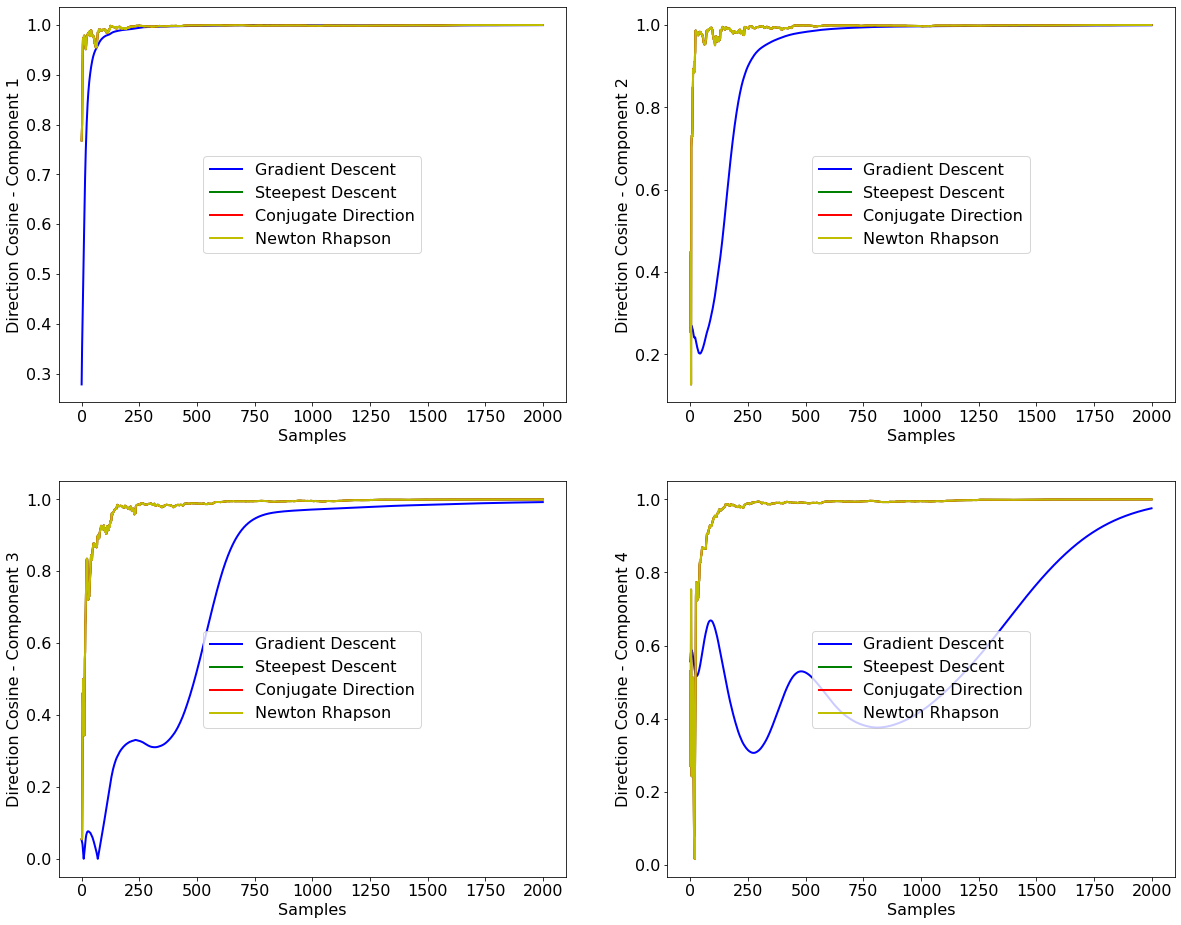

In [78]:
plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 16})

plt.subplot(2, 2, 1)
plt.plot(cos_t1[0,:], lw=2, color='b', label='Gradient Descent')
plt.plot(cos_t2[0,:], lw=2, color='g', label='Steepest Descent')
plt.plot(cos_t3[0,:], lw=2, color='r', label='Conjugate Direction')
plt.plot(cos_t4[0,:], lw=2, color='y', label='Newton Rhapson')
plt.ylabel('Direction Cosine - Component 1')
plt.xlabel('Samples')
plt.legend(loc="center")

plt.subplot(2, 2, 2)
plt.plot(cos_t1[1,:], lw=2, color='b', label='Gradient Descent')
plt.plot(cos_t2[1,:], lw=2, color='g', label='Steepest Descent')
plt.plot(cos_t3[1,:], lw=2, color='r', label='Conjugate Direction')
plt.plot(cos_t4[1,:], lw=2, color='y', label='Newton Rhapson')
plt.ylabel('Direction Cosine - Component 2')
plt.xlabel('Samples')
plt.legend(loc="center")

plt.subplot(2, 2, 3)
plt.plot(cos_t1[2,:], lw=2, color='b', label='Gradient Descent')
plt.plot(cos_t2[2,:], lw=2, color='g', label='Steepest Descent')
plt.plot(cos_t3[2,:], lw=2, color='r', label='Conjugate Direction')
plt.plot(cos_t4[2,:], lw=2, color='y', label='Newton Rhapson')
plt.ylabel('Direction Cosine - Component 3')
plt.xlabel('Samples')
plt.legend(loc="center")

plt.subplot(2, 2, 4)
plt.plot(cos_t1[3,:], lw=2, color='b', label='Gradient Descent')
plt.plot(cos_t2[3,:], lw=2, color='g', label='Steepest Descent')
plt.plot(cos_t3[3,:], lw=2, color='r', label='Conjugate Direction')
plt.plot(cos_t4[3,:], lw=2, color='y', label='Newton Rhapson')
plt.ylabel('Direction Cosine - Component 4')
plt.xlabel('Samples')
plt.legend(loc="center")

plt.show()